In [1]:
import random  # for reproducibility in sampling and shuffling
from pathlib import Path  # filesystem path manipulation

# 2. Data handling and preprocessing
import numpy as np  # numerical operations
import pandas as pd  # dataframes and tabular data

# 3. Visualization
import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # statistical data visualization

# 4. Deep learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# 5. Machine learning utilities (scikit-learn)
from sklearn.preprocessing import LabelEncoder, StandardScaler  # encoding labels and feature scaling
from sklearn.model_selection import train_test_split  # data splitting
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score  # evaluation metrics

# 6. Learning rate schedulers
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR  # dynamic LR scheduling

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Configure seaborn aesthetics
sns.set(style='whitegrid', context='notebook')

In [3]:
# Dataset file paths
TRAIN_CSV = "/kaggle/input/har-dataset-2/train_data_2.csv"  # Path to training data CSV
TEST_CSV  = "/kaggle/input/har-dataset-2/test_data_2.csv"   # Path to testing data CSV

# Windowing and batching parameters
WINDOW_SIZE = 600           # Number of timesteps per sliding window
BATCH_SIZE = 32             # Number of samples per training batch
SAMPLING_FREQ = 200         # Data sampling frequency in Hz
ADD_FEATS = False           # Whether to add derived features beyond raw sensor data

# Detect compute device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Processing Utilities and Dataset Preparation
This cell defines utility functions to select sensor channels, split data into training and validation sets, and loads, preprocesses, encodes, and wraps data in PyTorch datasets and dataloaders.

In [4]:
class DataPreprocessor:
    def __init__(self, window_size=600, sampling_freq=200, target_samples=32):
        self.window_size = window_size
        self.sampling_freq = sampling_freq
        self.target_samples = target_samples

    def moving_average_filter(self, data, window=8):
        return data.rolling(window=window, center=True).mean().fillna(data)

    def segment_data(self, data, overlap=0.7):
        segments = []
        labels_io = []
        labels_scene = []
        step_size = int(self.window_size * (1 - overlap))

        for i in range(0, len(data) - self.window_size, step_size):
            window = data.iloc[i:i+self.window_size]

            if len(window['I/O Detection'].unique()) == 1 and \
               len(window['Scene Identification'].unique()) == 1:
                segments.append(window)
                labels_io.append(window['I/O Detection'].iloc[0])
                labels_scene.append(window['Scene Identification'].iloc[0])

        return segments, labels_io, labels_scene

    def downsample_segment(self, segment, sensor_cols):
        downsampled = {}
        for col in sensor_cols:
            if col in segment.columns:
                original_data = segment[col].values
                indices = np.linspace(0, len(original_data) - 1, self.target_samples, dtype=int)
                downsampled[col] = original_data[indices]
            else:
                downsampled[col] = np.zeros(self.target_samples)
        return downsampled

    def z_score_normalize(self, segment_data):
        segment_array = np.array(list(segment_data.values())).T
        mean = np.mean(segment_array, axis=0)
        std = np.std(segment_array, axis=0)
        std = np.where(std == 0, 1, std)
        return (segment_array - mean) / std

    def extract_statistical_features(self, segment, sensor_cols):
        features = []
        for col in sensor_cols:
            if col in segment.columns:
                values = segment[col].values
                features.extend([
                    np.mean(values),
                    np.std(values),
                    np.min(values),
                    np.max(values)
                ])
        return features

    def preprocess_data(self, data, sensor_cols):
        filtered_data = data.copy()
        for col in sensor_cols:
            if col in data.columns:
                filtered_data[col] = self.moving_average_filter(data[col])

        segments, labels_io, labels_scene = self.segment_data(filtered_data)

        processed_segments = []
        statistical_features = []

        for segment in segments:
            if self.target_samples is not None:
                downsampled = self.downsample_segment(segment, sensor_cols)
                normalized = self.z_score_normalize(downsampled)
                processed_segments.append(normalized)
            else:
                processed_segments.append(segment[sensor_cols].values)

            stats = self.extract_statistical_features(segment, sensor_cols)
            statistical_features.append(stats)

        return np.array(processed_segments), np.array(statistical_features), labels_io, labels_scene

class HARDSdataset(Dataset):
    def __init__(self, X, y_io, y_scene, io_label_encoder, scene_label_encoder, statistical_features=None):
        self.X = torch.FloatTensor(X)
        self.y_io = torch.LongTensor(y_io)
        self.y_scene = torch.LongTensor(y_scene)
        self.statistical_features = statistical_features
        if statistical_features is not None:
            self.statistical_features = torch.FloatTensor(statistical_features)
        self.io_label_encoder = io_label_encoder
        self.scene_label_encoder = scene_label_encoder
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.statistical_features is not None:
            return self.X[idx], self.y_io[idx], self.y_scene[idx], self.statistical_features[idx]
        return self.X[idx], self.y_io[idx], self.y_scene[idx]

In [5]:
# Function to map high-level sensor names to their corresponding DataFrame columns
def get_sensors(sensor_list):
    # Dictionary of available sensor groups and their DataFrame columns
    available_sensors = {
        "Accelerometer": ["A_x [g]_y", "A_y [g]_y", "A_z [g]_y"],
        "Magnetometer": ["M_x [gauss]", "M_y [gauss]", "M_z [gauss]"],
        "Gyroscope": ["G_x [mdps]", "G_y [mdps]", "G_z [mdps]"],
        "Temperature": ["TEMP"],
        "Pressure": ["PRESS"],
    }

    # If user requests all sensors, return every column
    if sensor_list == 'all':
        return [col for cols in available_sensors.values() for col in cols]

    selected_sensors = []
    # Iterate through requested sensor names
    for sensor in sensor_list:
        # Raise error if sensor name is invalid
        if sensor not in available_sensors:
            raise ValueError(
                f"Sensor '{sensor}' is not available. Choose from {list(available_sensors.keys())}"
            )
        # Append all columns for the valid sensor
        selected_sensors.extend(available_sensors[sensor])

    return selected_sensors

# Function to split data arrays into train and validation subsets
def split_train_validation(X, y_io, y_scene, stats, val_split=0.2, stratify_on=None):
    # Use stratified split if a column is provided for stratification
    if stratify_on is not None:
        X_train, X_val, y_io_train, y_io_val, y_scene_train, y_scene_val, stats_train, stats_val = train_test_split(
            X, y_io, y_scene, stats,
            test_size=val_split,
            random_state=42,
            stratify=stratify_on
        )
    else:
        # Simple contiguous split if no stratification
        split_idx = int((1 - val_split) * len(X))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_io_train, y_io_val = y_io[:split_idx], y_io[split_idx:]
        y_scene_train, y_scene_val = y_scene[:split_idx], y_scene[split_idx:]
        stats_train, stats_val = stats[:split_idx], stats[split_idx:]

    return (
        X_train, X_val,
        y_io_train, y_io_val,
        y_scene_train, y_scene_val,
        stats_train, stats_val
    )

def print_distribution(name, labels, encoder):
    # labels: 1D array of encoded ints
    unique_lbls, counts = np.unique(labels, return_counts=True)
    print(f"\n=== {name} Set ===")
    for enc, cnt in zip(unique_lbls, counts):
        human = encoder.inverse_transform([enc])[0]
        print(f"  {human:>10s}: {cnt}")

# Prepare sensor list and data preprocessor
sensors = get_sensors('all')  # Retrieve all sensor columns
preprocessor = DataPreprocessor(window_size=WINDOW_SIZE, target_samples=None)

# Load raw CSV data
train_data = pd.read_csv(TRAIN_CSV)
test_data = pd.read_csv(TEST_CSV)

# Preprocess data into feature windows, stats, and labels
X_train, stats_train, y_io_train, y_scene_train = preprocessor.preprocess_data(train_data, sensors)
X_test, stats_test, y_io_test, y_scene_test = preprocessor.preprocess_data(test_data, sensors)

# Print data shapes and unique classes for sanity
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Unique I/O classes: {np.unique(y_io_train)}")
print(f"Unique Scene classes: {np.unique(y_scene_train)}")

# Encode string labels to integers for I/O and Scene tasks
io_encoder = LabelEncoder()
scene_encoder = LabelEncoder()

y_io_train_encoded = io_encoder.fit_transform(y_io_train)
y_scene_train_encoded = scene_encoder.fit_transform(y_scene_train)
y_io_test_encoded = io_encoder.transform(y_io_test)
y_scene_test_encoded = scene_encoder.transform(y_scene_test)

# Number of classes for each task
num_io_classes = len(io_encoder.classes_)
num_scene_classes = len(scene_encoder.classes_)

print(f"Number of I/O classes: {num_io_classes}")
print(f"Number of Scene classes: {num_scene_classes}")

# Split data into training and validation sets
X_train_split, X_val, y_io_train_split, y_io_val, y_scene_train_split, y_scene_val, stats_train_split, stats_val = split_train_validation(
    X_train, y_io_train_encoded, y_scene_train_encoded,
    stats_train,
    val_split=0.2,
    stratify_on=y_scene_train_encoded  # Stratify by scene class distribution
)

# Decode validation labels for potential inspection or debugging
y_io_val_decoded = io_encoder.inverse_transform(y_io_val)
y_scene_val_decoded = scene_encoder.inverse_transform(y_scene_val)

# %% [code]
# Create PyTorch datasets for train, validation, and test splits
train_dataset = HARDSdataset(X_train_split, y_io_train_split, y_scene_train_split, io_encoder, scene_encoder)
val_dataset = HARDSdataset(X_val, y_io_val, y_scene_val, io_encoder, scene_encoder)
test_dataset = HARDSdataset(X_test, y_io_test_encoded, y_scene_test_encoded, io_encoder, scene_encoder)

# Build DataLoaders for batching during training and evaluation
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Print dataset sizes for verification
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Val samples:   {len(val_loader.dataset)}")
print(f"Test samples:  {len(test_loader.dataset)}")

# Print dataset labels distributions
print_distribution("Train I/O",   train_dataset.y_io,    train_dataset.io_label_encoder)
print_distribution("Train Scene", train_dataset.y_scene, train_dataset.scene_label_encoder)

print_distribution("Val I/O",     val_dataset.y_io,      val_dataset.io_label_encoder)
print_distribution("Val Scene",   val_dataset.y_scene,   val_dataset.scene_label_encoder)

print_distribution("Test I/O",    test_dataset.y_io,     test_dataset.io_label_encoder)
print_distribution("Test Scene",  test_dataset.y_scene,  test_dataset.scene_label_encoder)

Training data shape: (21476, 600, 11)
Test data shape: (5342, 600, 11)
Unique I/O classes: ['Indoor' 'Outdoor']
Unique Scene classes: ['Bar' 'Hallway' 'Office' 'Street']
Number of I/O classes: 2
Number of Scene classes: 4
Train samples: 17180
Val samples:   4296
Test samples:  5342

=== Train I/O Set ===
      Indoor: 12321
     Outdoor: 4859

=== Train Scene Set ===
         Bar: 4000
     Hallway: 2611
      Office: 5710
      Street: 4859

=== Val I/O Set ===
      Indoor: 3081
     Outdoor: 1215

=== Val Scene Set ===
         Bar: 1000
     Hallway: 653
      Office: 1428
      Street: 1215

=== Test I/O Set ===
      Indoor: 3809
     Outdoor: 1533

=== Test Scene Set ===
         Bar: 828
     Hallway: 1097
      Office: 1884
      Street: 1533


In [ ]:
# Access the label encoders from your dataset object
io_encoder = train_loader.dataset.io_label_encoder
scene_encoder = train_loader.dataset.scene_label_encoder

# The .classes_ attribute holds the class names in order of their integer encoding (0, 1, 2, ...)
print("I/O Encoder Classes:", io_encoder.classes_)
print("Scene Encoder Classes:", scene_encoder.classes_)

# For a more robust way to use this in your code, create a mapping dictionary
io_map = {name: i for i, name in enumerate(io_encoder.classes_)}
scene_map = {name: i for i, name in enumerate(scene_encoder.classes_)}

print("\n--- Mappings ---")
print("I/O Mapping:", io_map)
print("Scene Mapping:", scene_map)

# Now you can directly use the names to get the encoding
print(f"\nEncoding for 'Indoor': {io_map['Indoor']}")
print(f"Encoding for 'Outdoor': {io_map['Outdoor']}")

# Depthwise Separable Convolution and Early-Exit CNN Module
This cell defines a depthwise-separable 1D convolution helper and the main Early-Exit CNN model with dynamic confidence-based exits and battery-aware thresholds.

In [6]:
def allowed_depth(battery_level):
    """
    Decide how deep we may go.
    battery_level is a scalar tensor in [0,1].
    Returns the highest exit index that is permitted.
    """
    # collapse a batch to a single scalar
    if battery_level.dim() > 0:
        batt = battery_level.min()
    else:
        batt = battery_level
    lvl = batt.item()
    if lvl < 0.25:
        return 1
    elif lvl > 0.60:
        return 2
    # elif lvl < 0.65:
    #     return 2
    # return 3

def map_battery(b, k=10.0, center=0.5):
    """
    Map battery_level to sensitivity curve via sigmoid centered at 0.5.
    More sensitive around mid battery range.
    """
    return torch.sigmoid(k*(b-center))

In [7]:
# Helper: depthwise separable 1D convolution block
def depthwise_separable_conv1d(in_ch, out_ch, kernel_size, stride=1, padding=0, drop_p=0.3):
    """
    Constructs a depthwise separable convolution:
    1) Depthwise Conv1d for channel-wise spatial filtering
    2) BatchNorm + ReLU activation
    3) Dropout
    4) Pointwise Conv1d (1×1) for channel mixing
    5) BatchNorm + ReLU activation
    6) Dropout
    """
    return nn.Sequential(
        nn.Conv1d(
            in_channels=in_ch, out_channels=in_ch,
            kernel_size=kernel_size, stride=stride,
            padding=padding, groups=in_ch, bias=False
        ),
        nn.BatchNorm1d(in_ch),
        nn.ReLU(inplace=True),
        nn.Dropout(drop_p),
        nn.Conv1d(
            in_channels=in_ch, out_channels=out_ch,
            kernel_size=1, stride=1, padding=0, bias=False
        ),
        nn.BatchNorm1d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout(drop_p)
    )

class DepthwiseEarlyExitCNN1D(nn.Module):
    def __init__(self, if_train, train_shape, n_io, n_scene, drop_p=0.3):
        super().__init__()
        self.if_train = if_train
        self.drop_p = drop_p
        seq_len, n_sensors = train_shape

        # Threshold parameters for the first exit
        self.thr0_logit_eff = nn.Parameter(torch.tensor(2.94))
        self.thr0_logit_perf = nn.Parameter(torch.tensor(0.85))

        # Backbone: sequence of separable conv blocks
        self.backbone = nn.ModuleList([
            nn.Sequential(
                depthwise_separable_conv1d(n_sensors, 16, kernel_size=6, stride=3, padding=2, drop_p=drop_p),
                depthwise_separable_conv1d(16, 32, kernel_size=5, stride=2, padding=2, drop_p=drop_p)
            ),
            depthwise_separable_conv1d(32, 48, kernel_size=3, stride=2, padding=1, drop_p=drop_p)
        ])

        # Exit heads (no change here)
        self.exits = nn.ModuleList([
            nn.Sequential(nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(32, n_io)),
            nn.Sequential(nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(48, n_scene)),
        ])

        # Adapter to make out0 compatible with the scene task
        self.ensemble_adapter = nn.Linear(n_io, n_scene)
        
        # --- NEW: The Gating Mechanism ---
        # This small network learns to weigh the raw features vs. the prior context.
        # It takes the features from backbone[1] (which have 48 channels) as input.
        self.gate = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(48, 1),
            nn.Sigmoid()
        )

    def get_confidence(self, logits):
        """Return max softmax confidence per sample."""
        return F.softmax(logits, dim=-1).max(dim=-1)[0]

    # --- MODIFIED: The forward pass now uses the gate ---
    def forward(self, x, battery_level=1.0):
        """
        Forward pass with advanced gating for the final exit.
        """
        # --- Input permutation and threshold calculation (no change) ---
        x = x.permute(0, 2, 1)
        thr0_high_confidence = torch.sigmoid(self.thr0_logit_eff)
        thr0_low_confidence = torch.sigmoid(self.thr0_logit_perf)
        alpha = map_battery(battery_level, k=10.0, center=0.5)
        current_thr0 = thr0_high_confidence + (thr0_low_confidence - thr0_high_confidence) * alpha

        # --- Stage 1 computations ---
        x0 = self.backbone[0](x)
        out0 = self.exits[0](x0)

        # --- Stage 2 computations ---
        x1 = self.backbone[1](x0)
        raw1 = self.exits[1](x1)

        # --- Gated Fusion Logic ---
        # 1. Calculate the gate value from the features at this stage (x1)
        gate_value = self.gate(x1)
        # 2. Adapt the output from the first exit
        #    (detach during training to treat it as a fixed target for the fusion)
        adapted_out0 = self.ensemble_adapter(out0.detach() if self.if_train else out0)
        # 3. Combine using the learned gate
        out1_ensembled = (gate_value * raw1) + ((1.0 - gate_value) * adapted_out0)
        
        # =================================================================
        # ========== TRAINING FORWARD PASS (if self.if_train) =============
        # =================================================================
        if self.if_train:
            with torch.no_grad():
                conf0 = self.get_confidence(out0)
                should_exit0 = (conf0 >= current_thr0).float()
                should_exit1 = 1.0 - should_exit0
                p_exits = torch.stack([should_exit0, should_exit1], dim=1)
            
            return [out0, out1_ensembled], p_exits

        # =================================================================
        # ========== INFERENCE FORWARD PASS (if not self.if_train) ========
        # =================================================================
        depth_cap = allowed_depth(battery_level)
        if depth_cap == 1 or self.get_confidence(out0).item() < current_thr0.item():
            return [out0], 1
        
        # If we didn't exit, return the already computed ensembled output
        return [out0, out1_ensembled], 2

# Training and Evaluation Loop
The following function runs one epoch over the dataset, computing classification loss, expected computational cost loss, and updating model parameters when in training mode.

In [8]:
def _top1_correct(logits: torch.Tensor, labels: torch.Tensor):
    """Returns (#correct, #samples) for top-1 accuracy."""
    return (logits.argmax(dim=1) == labels).sum().item(), labels.size(0)

# main ────────────────────────────────────────────────────────────────────────
def run_epoch(model, loader, criterion, optimizer, scheduler, train, lambda_cost=0.05, exit_costs=(0.4, 1.0), battery_sampler=None):
    """
    Returns
    -------
    losses : dict
        { 'total', 'cls', 'cost', 'exp_acc' }
    accs   : dict
        { 'io@0', 'sc@1', 'cov' }   # cov = coverage vector
    """
    model.if_train = True           # ensures the forward pass emits p_exits during training
    model.train() if train else model.eval()

    # accumulators -----------------------------------------------------------
    # --- CORRECTED: Removed references to the third exit ---
    stats = {
        "loss_total" : 0.,
        "loss_cls"   : 0.,
        "loss_cost"  : 0.,
        "exp_acc"    : 0.,          # expected overall accuracy
        "n"          : 0,
        "io_corr"    : 0,
        "sc1_corr"   : 0,
        "cov"        : torch.zeros(2, device=device)   # Exit coverage is now size 2
    }
    # --- CORRECTED: exit_costs now only has two elements ---
    exit_costs = torch.tensor(exit_costs, device=device)

    # ------------------------------------------------------------------------
    with torch.set_grad_enabled(train):
        for feats, io_lbls, sc_lbls in loader:
            feats   = feats.float().to(device)          # [B,T,C]
            io_lbls = io_lbls.view(-1).to(device)     # always (B,) regardless of original shape
            sc_lbls = sc_lbls.view(-1).to(device)
            B = feats.size(0)

            # battery profile for this mini-batch
            batt = battery_sampler(B).to(device) if battery_sampler else torch.ones(B, device=device)

            # --- CORRECTED: The model now returns a list of 2 logits ---
            # And p_exits will have shape [B, 2]
            (e0, e1), p_exits = model(feats, battery_level=batt)

            # ─── classification loss (per exit) -----------------------------
            loss_e0 = criterion(e0, io_lbls)
            loss_e1 = criterion(e1, sc_lbls)
            # Removed loss_e2

            # --- CORRECTED: Simplified loss weighting ---
            # Using Ascending Weights Loss for the two exits
            w0, w1 = 2.0, 10.0  # Example weights: penalize the final exit more
            cls_loss = (w0 * loss_e0 + w1 * loss_e1) / (w0 + w1)

            # ─── expected cost ---------------------------------------------
            # This logic remains correct, as p_exits and exit_costs are now both size 2
            cost_loss = (p_exits * exit_costs).sum(dim=1).mean()

            # ─── total loss -------------------------------------------------
            loss = cls_loss + lambda_cost * cost_loss

            # ─── optimiser step --------------------------------------------
            if train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            # ─── stats update ----------------------------------------------
            stats["loss_total"] += loss.item()      * B
            stats["loss_cls"]   += cls_loss.item() * B
            stats["loss_cost"]  += cost_loss.item()* B
            stats["n"]          += B

            # --- CORRECTED: Only calculate accuracy for the two existing exits ---
            c, _ = _top1_correct(e0, io_lbls);  stats["io_corr"]  += c
            c, _ = _top1_correct(e1, sc_lbls);  stats["sc1_corr"] += c
            # Removed sc2_corr calculation

            # --- CORRECTED: correct_vec now has two elements ---
            # expected overall acc  (per-sample expectation)
            correct_vec = torch.stack([
                (e0.argmax(1) == io_lbls),          # bool → 0/1
                (e1.argmax(1) == sc_lbls),
            ], dim=1).float()                      # shape [B, 2]

            stats["exp_acc"] += (p_exits * correct_vec).sum().item()
            stats["cov"]     += p_exits.sum(dim=0)           # coverage counts

    # ─── normalise -----------------------------------------------------------
    n = stats["n"]
    losses = {
        "total"   : stats["loss_total"] / n,
        "cls"     : stats["loss_cls"]   / n,
        # "cost"    : stats["cost"]      / n,
        "exp_acc" : stats["exp_acc"]    / n
    }
    # --- CORRECTED: Updated the accs dictionary ---
    accs = {
        "io@0" : stats["io_corr"]  / n,
        "sc@1" : stats["sc1_corr"] / n,
        "cov"  : (stats["cov"] / n).tolist()        # e.g. [0.7, 0.3]
    }
    return losses, accs

In [9]:
def battery_sampler_uniform(batch_size):
    """
    Returns a tensor of shape (batch_size,)
    with battery levels sampled uniformly in [0, 1].
    """
    return torch.rand(batch_size)

def battery_sampler_beta(batch_size, alpha=2.0, beta=5.0):
    """
    Returns a tensor of shape (batch_size,)
    with battery levels sampled from a Beta distribution.
    
    Parameters:
    - alpha, beta: shape parameters of the Beta distribution.
      A Beta(2,5) mimics a device which spends more time at lower charge.
    """
    return torch.distributions.Beta(alpha, beta).sample((batch_size,))

def battery_sampler_schedule(batch_size, start=1.0, end=0.0, epoch=0, total_epochs=100):
    """
    Returns a tensor where battery levels linearly decay over training epochs.
    Useful for curriculum learning.
    
    Parameters:
    - start: initial battery level at epoch=0
    - end: final battery level at epoch=total_epochs
    - epoch: current epoch index
    - total_epochs: total number of epochs
    """
    level = start + (end - start) * (epoch / (total_epochs - 1))
    return torch.full((batch_size,), level)

# def battery_sampler_schedule(bs, epoch, total_epochs):
#     # A rapid drop after 70 % (Li-ion plateau), then flat, then tail
#     pct = epoch / total_epochs
#     level = 1.0 - (0.9*pct**0.5 + 0.1*pct)      # convex curve
#     noise  = torch.randn(bs)*0.05               # small diversity
#     return torch.clamp(torch.full((bs,), level) + noise, 0, 1)

In [10]:
def train_model(train_loader, val_loader, hparams, save_dir, run_name):
    run_save_dir = Path(save_dir) / run_name
    run_save_dir.mkdir(parents=True, exist_ok=True)

    # ── model ----------------------------------------------------------------
    sample_shape = train_loader.dataset[0][0].shape
    model = DepthwiseEarlyExitCNN1D(
        True,
        sample_shape,
        len(train_loader.dataset.io_label_encoder.classes_),
        len(train_loader.dataset.scene_label_encoder.classes_),
        drop_p=hparams["drop_p"]
    ).to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=hparams["lr"], weight_decay=hparams["weight_decay"])

    # ── scheduler ------------------------------------------------------------
    if hparams["scheduler"] == "step":
        scheduler = StepLR(optimizer, step_size=hparams["step_size"], gamma=0.5)
    elif hparams["scheduler"] == "plateau":
        scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5, min_lr=1e-7)
    elif hparams["scheduler"] == "onecycle":
        total_steps = hparams["epochs"] * len(train_loader)
        scheduler = OneCycleLR(optimizer, max_lr=1e-2, total_steps=total_steps, pct_start=hparams["pc"], div_factor=hparams["divfactor"], final_div_factor=1e4)
    else:
        raise ValueError(f"Unsupported scheduler: {hparams['scheduler']}")

    # ── early-stopping config -----------------------------------------------
    monitor            = "exp_acc"          # change to "cls" etc. if you want
    higher_is_better   = True               # flip if you monitor a loss
    min_delta          = 1e-4
    patience           = 5

    best_value         = -float("inf") if higher_is_better else float("inf")
    epochs_no_improve  = 0
    history            = []

    # ── epoch loop -----------------------------------------------------------
    for epoch in range(1, hparams["epochs"] + 1):

        # ---- train ----------------------------------------------------------
        tr_losses, tr_accs = run_epoch(
            model, train_loader, criterion, optimizer, scheduler,
            train=True,
            lambda_cost=hparams["lambda_cost"],
            battery_sampler=lambda bs: battery_sampler_schedule(bs, epoch=epoch, total_epochs=hparams["epochs"])
        )

        # ---- validation -----------------------------------------------------
        vl_losses, vl_accs = run_epoch(
            model, val_loader, criterion, None, None,
            train=False,
            lambda_cost= hparams["lambda_cost"],
            battery_sampler=lambda bs: torch.ones(bs, device=device)
        )

        # ---- scheduler step -------------------------------------------------
        if hparams["scheduler"] == "step":
            scheduler.step()
        elif hparams["scheduler"] == "plateau":
            scheduler.step(vl_losses[monitor])
        elif hparams["scheduler"] == "onecycle":
            scheduler.step()

        # ---- pretty log -----------------------------------------------------
        cov_tr = [f"{c:.2%}" for c in tr_accs["cov"]]
        cov_vl = [f'{c:.2%}' for c in vl_accs["cov"]]
        print(
            f"Ep {epoch:03d} | "
            f"tr L:{tr_losses['total']:.3f} "
            # f"(cls:{tr_losses['cls']:.3f} cost:{tr_losses['cost']:.3f}) "
            f"IO[{tr_accs['io@0']:.2%}] "
            f"SC[{tr_accs['sc@1']:.2%}] "
            f"ExpAcc:{tr_losses['exp_acc']:.2%} "
            f"cov:{cov_tr} || "
            f"vl L:{vl_losses['total']:.3f} "
            # f"(cls:{vl_losses['cls']:.3f} cost:{vl_losses['cost']:.3f}) "
            f"IO[{vl_accs['io@0']:.2%}] "
            f"SC[{vl_accs['sc@1']:.2%}] "
            f"ExpAcc:{vl_losses['exp_acc']:.2%} "
            f"cov:{cov_vl}"
        )

        # ---- early-stopping -------------------------------------------------
        curr_value = vl_losses[monitor]
        improved = (curr_value > best_value + min_delta) if higher_is_better else (curr_value < best_value - min_delta)

        if improved:
            best_value        = curr_value
            epochs_no_improve = 0
            torch.save(model.state_dict(), run_save_dir / "best_model.pth")
            print(f" -> Saved best model ({monitor}: {best_value:.4f})")
        else:
            epochs_no_improve += 1
            print(f" -> No improvement on {monitor} "
                  f"({epochs_no_improve}/{patience})")

        if epochs_no_improve >= patience:
            print(f" -> Early stopping at epoch {epoch}")
            break

        # ---- bookkeeping ----------------------------------------------------
        history.append({
            "epoch" : epoch,
            **{f"tr_{k}": v for k, v in tr_losses.items()},
            **{f"vl_{k}": v for k, v in vl_losses.items()},
            **{f"tr_{k}": v for k, v in tr_accs.items() if k != "cov"},
            **{f"vl_{k}": v for k, v in vl_accs.items() if k != "cov"},
        })

    print(f"END RUN: {run_name} | best {monitor}: {best_value:.4f}")
    return history

In [11]:
# List of hyperparameter combinations to explore
hyperparameter_space = [
    # {'lr': 1e-3, 'weight_decay': 1e-4, 'scheduler': 'onecycle', 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'pc': 0.15, 'divfactor': 18.0, 'x': 5},
    # {'lr': 1e-3, 'weight_decay': 1e-4, 'scheduler': 'onecycle', 'epochs': 50, 'lambda_cost': 0.05, 'drop_p': 0.0, 'pc': 0.70, 'divfactor': 18.0, 'x': 9},
    # {'lr': 3e-4, 'weight_decay': 1e-5, 'scheduler': 'step', 'step_size': 20, 'epochs': 30, 'lambda_cost': 0.05, 'drop_p': 0.0, 'x': 64}, # BEST EVER !!!!!!!! # 27 kB
    # {'lr': 3e-4, 'weight_decay': 1e-5, 'scheduler': 'step', 'step_size': 20, 'epochs': 30, 'lambda_cost': 0.05, 'drop_p': 0.0, 'x': 15}, # BEST EVER !!!!!!!! # 52Kb
    # {'lr': 3e-4, 'weight_decay': 1e-5, 'scheduler': 'step', 'step_size': 20, 'epochs': 30, 'lambda_cost': 0.05, 'drop_p': 0.0, 'x': 90},
    # {'lr': 3e-4, 'weight_decay': 5e-5, 'scheduler': 'step', 'step_size': 20, 'epochs': 30, 'lambda_cost': 0.05, 'drop_p': 0.0, 'x': 91},
    {'lr': 3e-4, 'weight_decay': 5e-5, 'scheduler': 'step', 'step_size': 20, 'epochs': 30, 'lambda_cost': 0.05, 'drop_p': 0.0, 'x': 92},
    # {'lr': 5e-4, 'weight_decay': 1e-5, 'scheduler': 'step', 'step_size': 10, 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 4}, # BEST
    # {'lr': 7e-4, 'weight_decay': 1e-5, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 4}, # BEST

    # {'lr': 2e-2, 'weight_decay': 5e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 1}, # HIGH ACC BUT BAD CURVE
    # {'lr': 2e-2, 'weight_decay': 5e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.05, 'drop_p': 0.0, 'x': 2},
    # {'lr': 2e-2, 'weight_decay': 5e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.1, 'drop_p': 0.0, 'x': 3}, 
    # {'lr': 1e-2, 'weight_decay': 5e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 40}, # QUITE GOOD
    # {'lr': 1e-3, 'weight_decay': 1e-4, 'scheduler': 'onecycle', 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'pc': 0.10, 'divfactor': 25.0, 'x': 20}, # il migliore
    # {'lr': 5e-3, 'weight_decay': 5e-4, 'scheduler': 'onecycle', 'epochs': 20, 'lambda_cost': 0.0, 'drop_p': 0.0, 'pc': 0.10, 'divfactor': 30.0, 'x': 20}, # il migliore
    # {'lr': 5e-3, 'weight_decay': 1e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 20, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 40}, # QUITE GOOD
]

# Directory to save checkpoint runs
SAVE_DIR = "/kaggle/working/validation_runs"

# Dictionary to collect training histories
all_histories = {}
for hparams in hyperparameter_space:
    # Construct a short run name for saving and lookup
    run_name = f"LR_{hparams['lr']}_WD_{hparams['weight_decay']}_SCH_{hparams['scheduler']}_DROP_{hparams['drop_p']}_X{hparams['x']}"
    print(f'\nTraining: {run_name}')
    # Train the model with the given hyperparameters
    history = train_model(
        train_loader=train_loader,
        val_loader=val_loader,
        hparams=hparams,
        save_dir=SAVE_DIR,
        run_name=run_name
    )
    # Store history for analysis and comparison
    all_histories[run_name] = history

print("Hyperparameter tuning completed.")


Training: LR_0.0003_WD_5e-05_SCH_step_DROP_0.0_X92
Ep 001 | tr L:1.020 IO[71.37%] SC[60.96%] ExpAcc:66.88% cov:['24.56%', '75.44%'] || vl L:0.861 IO[76.42%] SC[70.88%] ExpAcc:81.54% cov:['46.00%', '54.00%']
 -> Saved best model (exp_acc: 0.8154)
Ep 002 | tr L:0.850 IO[79.41%] SC[69.83%] ExpAcc:83.59% cov:['54.87%', '45.13%'] || vl L:0.801 IO[81.26%] SC[73.37%] ExpAcc:86.17% cov:['61.15%', '38.85%']
 -> Saved best model (exp_acc: 0.8617)
Ep 003 | tr L:0.804 IO[82.00%] SC[73.14%] ExpAcc:85.63% cov:['63.47%', '36.53%'] || vl L:0.758 IO[82.61%] SC[76.16%] ExpAcc:87.73% cov:['69.30%', '30.70%']
 -> Saved best model (exp_acc: 0.8773)
Ep 004 | tr L:0.776 IO[83.61%] SC[74.94%] ExpAcc:86.66% cov:['67.11%', '32.89%'] || vl L:0.742 IO[85.59%] SC[77.44%] ExpAcc:86.94% cov:['69.04%', '30.96%']
 -> No improvement on exp_acc (1/5)
Ep 005 | tr L:0.752 IO[84.30%] SC[77.06%] ExpAcc:87.68% cov:['69.36%', '30.64%'] || vl L:0.709 IO[85.92%] SC[79.40%] ExpAcc:88.48% cov:['72.81%', '27.19%']
 -> Saved best 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

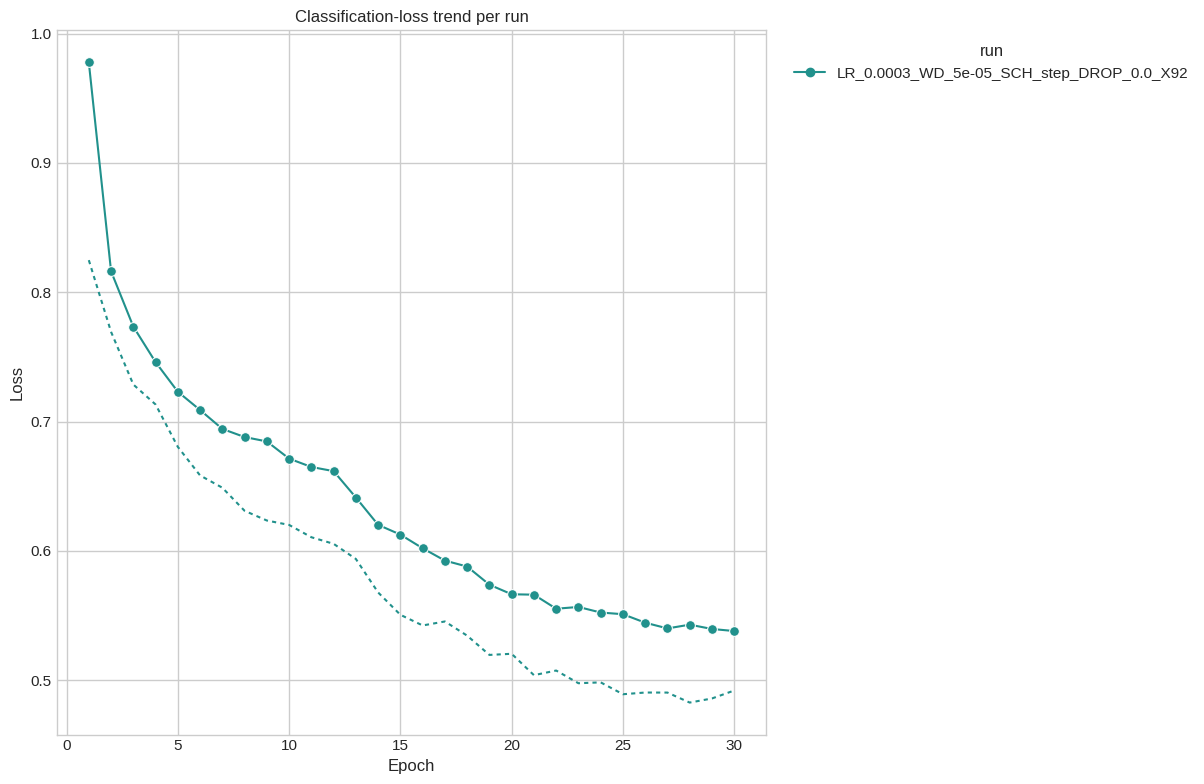

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

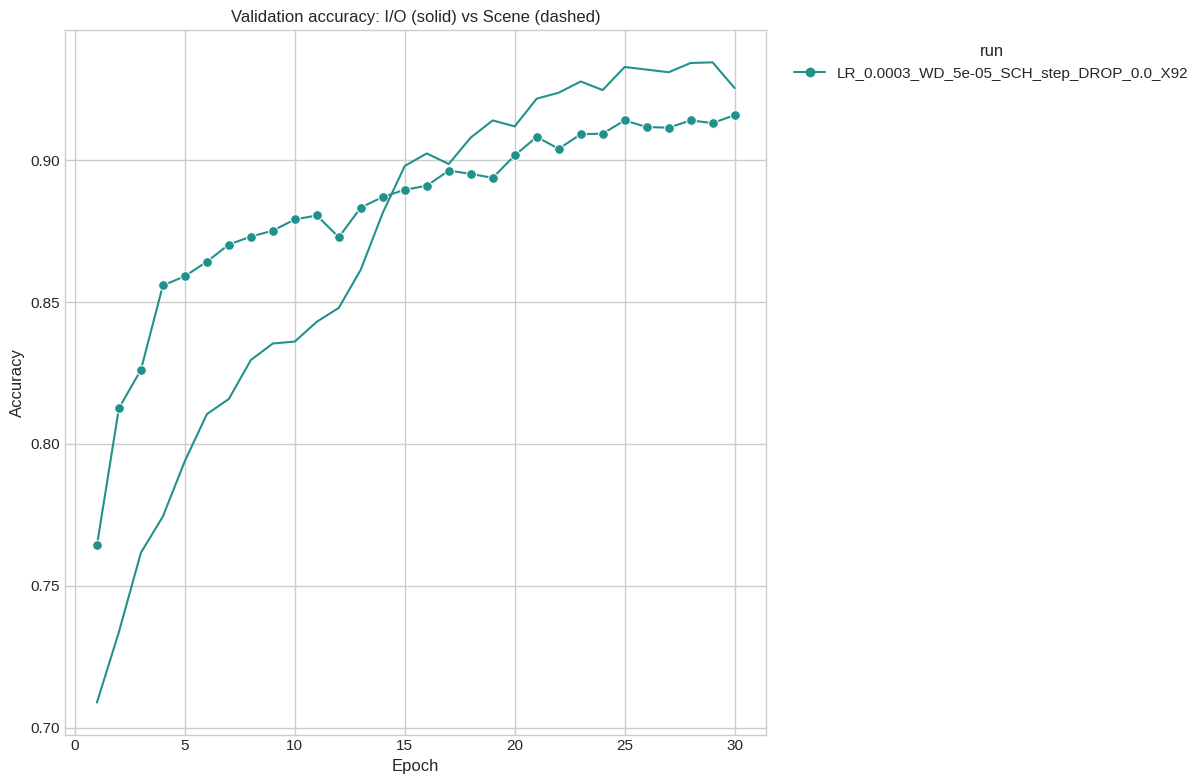

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


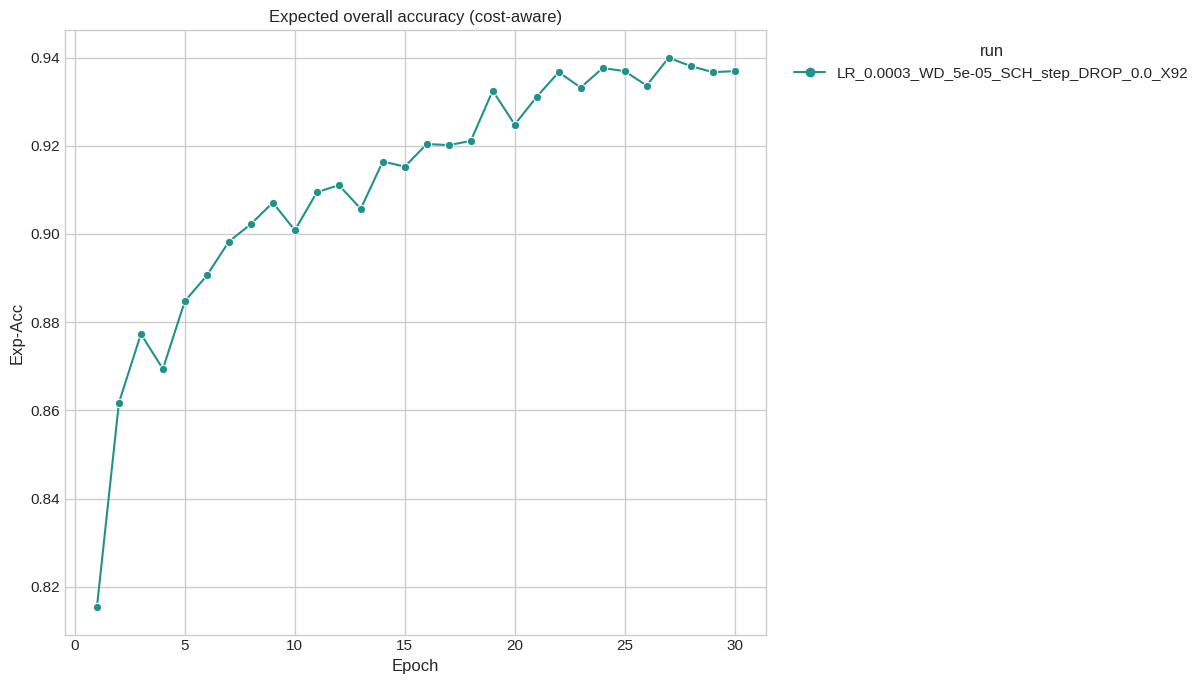

In [12]:
plot_data = []
for run_name, history in all_histories.items():
    for ep in history:
        ep["run_name"] = run_name
        plot_data.append(ep)

df = pd.DataFrame(plot_data)

# convenience: average scene accuracy over exits 1 & 2
df["vl_scene_avg"] = df["vl_sc@1"]
df["tr_scene_avg"] = df["tr_sc@1"]

run_names = df["run_name"].unique()
n_runs    = len(run_names)

# ------------------------------------ #
# 1.  LOSS curves (classification)      #
# ------------------------------------ #
plt.style.use("seaborn-v0_8-whitegrid")
palette   = sns.color_palette("viridis", n_colors=n_runs)
markers   = dict(zip(run_names, ['o','s','^','P','D','X','*','+']))

fig, ax1 = plt.subplots(figsize=(15,8))

sns.lineplot(
    data   = df,
    x      = "epoch",
    y      = "tr_cls",
    hue    = "run_name",
    style  = "run_name",
    dashes = False,
    markers= markers,
    palette= palette,
    ax     = ax1,
    legend = "full",
    markersize = 7
)

sns.lineplot(
    data   = df,
    x      = "epoch",
    y      = "vl_cls",
    hue    = "run_name",
    style  = "run_name",
    dashes = {r:(2,2) for r in run_names},   # dashed for validation
    palette= palette,
    ax     = ax1,
    legend = False
)

ax1.set(
    title = "Classification-loss trend per run",
    xlabel= "Epoch",
    ylabel= "Loss"
)
ax1.legend(title="run", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(rect=[0,0,0.82,1])
plt.show()

# ------------------------------------ #
# 2.  VALIDATION accuracies             #
# ------------------------------------ #
fig, ax2 = plt.subplots(figsize=(15,8))

# I/O exit (exit-0) – solid & markers
sns.lineplot(
    data   = df,
    x      = "epoch",
    y      = "vl_io@0",
    hue    = "run_name",
    style  = "run_name",
    markers= markers,
    dashes = False,
    palette= palette,
    ax     = ax2,
    legend = "full",
    markersize = 7
)

# Scene (avg of exits 1+2) – dashed, no markers
sns.lineplot(
    data   = df,
    x      = "epoch",
    y      = "vl_scene_avg",
    hue    = "run_name",
    style  = "run_name",
    dashes = True,
    markers= False,
    palette= palette,
    ax     = ax2,
    legend = False
)

ax2.set(
    title = "Validation accuracy: I/O (solid) vs Scene (dashed)",
    xlabel= "Epoch",
    ylabel= "Accuracy"
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:n_runs], labels[:n_runs],
           bbox_to_anchor=(1.02,1), loc="upper left", title="run")
plt.tight_layout(rect=[0,0,0.82,1])
plt.show()

# ------------------------------------ #
# 3.  Expected accuracy vs cost (extra) #
# ------------------------------------ #
fig, ax3 = plt.subplots(figsize=(15,7))
sns.lineplot(
    data   = df,
    x      = "epoch",
    y      = "vl_exp_acc",
    hue    = "run_name",
    style  = "run_name",
    markers= markers,
    palette= palette,
    ax     = ax3,
    markersize=6
)
ax3.set(title="Expected overall accuracy (cost-aware)", xlabel="Epoch", ylabel="Exp-Acc")
ax3.legend(bbox_to_anchor=(1.02,1), loc="upper left", title="run")
plt.tight_layout(rect=[0,0,0.82,1])
plt.show()

In [13]:
def evaluate_model_performance(model, loader, battery_level):
    model.eval()
    model.if_train = False

    # --- CORRECTED: Accumulators pruned for a 2-exit model ---
    total_samples      = 0
    overall_correct    = 0
    exit_counts        = {1: 0, 2: 0}
    correct_at_exit    = {1: 0, 2: 0}
    correct_io_later   = {2: 0}

    # I/O F1 lists
    y_true_io_all, y_pred_io_all = [], []
    y_true_io_at_exit2, y_pred_io_at_exit2 = [], []

    # Scene F1 lists
    y_true_scene_all, y_pred_scene_all = [], []
    y_true_scene_at_exit2_raw,  y_pred_scene_at_exit2_raw  = [], []
    y_true_scene_at_exit2_final, y_pred_scene_at_exit2_final = [], []

    scene_encoder = loader.dataset.scene_label_encoder
    street_label_int  = list(scene_encoder.classes_).index('Street')
    outdoor_label_int = list(loader.dataset.io_label_encoder.classes_).index('Outdoor')

    with torch.no_grad():
        for feats, io_lbls, sc_lbls in loader:
            total_samples += 1

            # --- setup ---
            assert feats.size(0) == 1, "eval expects bs=1"
            feats   = feats.float().to(device)
            io_lbls = io_lbls.view(-1).to(device).long()
            sc_lbls = sc_lbls.view(-1).to(device).long()
            batt = torch.tensor([battery_level], device=device)

            # --- forward pass ---
            outs, exit_idx = model(feats, battery_level=batt)
            final_computational_exit = int(exit_idx)
            exit_counts[final_computational_exit] += 1

            # 1) I/O prediction from head 0 (always available)
            io_pred = outs[0].argmax(1)
            y_true_io_all.append(io_lbls.item())
            y_pred_io_all.append(io_pred.item())

            # 2) Scene raw prediction (only if exit 2)
            raw_scene_pred = None
            if final_computational_exit == 2:
                # outs[1] is the ensembled scene prediction
                raw_scene_pred = outs[1].argmax(1).item()

                # I/O strictly for exit 2
                y_true_io_at_exit2.append(io_lbls.item())
                y_pred_io_at_exit2.append(io_pred.item())

                # Scene raw (head-only) for exit 2
                y_true_scene_at_exit2_raw.append(sc_lbls.item())
                y_pred_scene_at_exit2_raw.append(raw_scene_pred)
            
            # 3) Post-hoc rule (Outdoor -> Street)
            final_scene_pred = raw_scene_pred
            if io_pred.item() == outdoor_label_int and final_scene_pred is not None:
                final_scene_pred = street_label_int

            # Collect per-exit "final" scene (after correction)
            if final_computational_exit == 2 and final_scene_pred is not None:
                y_true_scene_at_exit2_final.append(sc_lbls.item())
                y_pred_scene_at_exit2_final.append(final_scene_pred)

            # Overall Scene (after correction) across E2
            if final_scene_pred is not None:
                y_true_scene_all.append(sc_lbls.item())
                y_pred_scene_all.append(final_scene_pred)

            # 4) Per-sample correctness
            is_io_correct = (io_pred == io_lbls).item()
            is_scene_correct = (final_scene_pred is not None) and (final_scene_pred == sc_lbls.item())

            # Overall "task done" correctness:
            if final_computational_exit == 1:
                if is_io_correct:
                    overall_correct += 1
            else:  # exit 2 -> require both I/O and Scene correct
                if is_io_correct and is_scene_correct:
                    overall_correct += 1

            # Accuracy-at-exit counters
            if final_computational_exit == 1:
                correct_at_exit[1] += int(is_io_correct)
            elif final_computational_exit == 2:
                correct_at_exit[2] += int(is_scene_correct)
                correct_io_later[2] += int(is_io_correct)

    # --- Aggregation ---
    total = total_samples
    n1, n2 = exit_counts[1], exit_counts[2]
    c1, c2 = correct_at_exit[1], correct_at_exit[2]

    # --- CORRECTED: F1 scores ---
    f1_io_all_w = f1_score(y_true_io_all, y_pred_io_all, average='weighted', zero_division=0)
    f1_io_exit2_w = f1_score(y_true_io_at_exit2, y_pred_io_at_exit2, average='weighted', zero_division=0) if y_true_io_at_exit2 else 0.0

    f1_scene_all_w = f1_score(y_true_scene_all, y_pred_scene_all, average='weighted', zero_division=0) if y_true_scene_all else 0.0
    f1_scene_exit2_raw_w = f1_score(y_true_scene_at_exit2_raw, y_pred_scene_at_exit2_raw, average='weighted', zero_division=0) if y_true_scene_at_exit2_raw else 0.0
    f1_scene_exit2_final_w = f1_score(y_true_scene_at_exit2_final, y_pred_scene_at_exit2_final, average='weighted', zero_division=0) if y_true_scene_at_exit2_final else 0.0

    # --- CORRECTED: Final results dictionary ---
    return {
        'battery_level': battery_level,
        'exit_rates': {
            'exit1': n1/total*100 if total else 0,
            'exit2': n2/total*100 if total else 0,
        },
        'accuracy_at_exit': {
            'io@1': c1/n1 if n1 else 0,
            'io@2': correct_io_later[2]/n2 if n2 else 0,
            'scene@2': c2/n2 if n2 else 0,
        },
        'f1_weighted_at_exit': {
            'f1_io_at_exit2': f1_io_exit2_w,
            'f1_scene_exit2_raw': f1_scene_exit2_raw_w,
            'f1_scene_exit2_final': f1_scene_exit2_final_w,
        }
    }

BEST_MODEL_PATH = "/kaggle/working/validation_runs/LR_0.0003_WD_5e-05_SCH_step_DROP_0.0_X92/best_model.pth"

model = DepthwiseEarlyExitCNN1D(
    if_train=False,
    train_shape=train_loader.dataset[0][0].shape,
    n_io=len(train_dataset.io_label_encoder.classes_),
    n_scene=len(train_dataset.scene_label_encoder.classes_)
).to(device)

# Load the weights of your chosen best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

# You can test any battery levels you want
battery_levels = np.linspace(0.6, 1.0, 4) # Example: test at 0, 0.25, 0.5, 0.75, 1.0

for b in battery_levels:
    results = evaluate_model_performance(model, test_loader, battery_level=b)
    
    # --- CORRECTED: Updated print statements ---
    print(f"--- Eval @ batt={b:.2f} | Rates: {results['exit_rates']} ---")
    print(f"Accuracies: {results['accuracy_at_exit']}")
    print(f"F1 Weighted: {results['f1_weighted_at_exit']}")
    print("-"*50 + "\n")

--- Eval @ batt=0.60 | Rates: {'exit1': 33.545488581055785, 'exit2': 66.45451141894422} ---
Accuracies: {'io@1': 0.7131696428571429, 'io@2': 0.979718309859155, 'scene@2': 0.8746478873239436}
F1 Weighted: {'f1_io_at_exit2': 0.9796481059314054, 'f1_scene_exit2_raw': 0.8798878496299399, 'f1_scene_exit2_final': 0.8768916500121078}
--------------------------------------------------

--- Eval @ batt=0.73 | Rates: {'exit1': 26.78771995507301, 'exit2': 73.21228004492698} ---
Accuracies: {'io@1': 0.6722571628232006, 'io@2': 0.9700843773970852, 'scene@2': 0.8540015341344924}
F1 Weighted: {'f1_io_at_exit2': 0.9699212368360339, 'f1_scene_exit2_raw': 0.861937832076017, 'f1_scene_exit2_final': 0.8573511904483332}
--------------------------------------------------

--- Eval @ batt=0.87 | Rates: {'exit1': 24.4852115312617, 'exit2': 75.5147884687383} ---
Accuracies: {'io@1': 0.658256880733945, 'io@2': 0.9655428854734754, 'scene@2': 0.8477937530986613}
F1 Weighted: {'f1_io_at_exit2': 0.9653012972369197,

In [ ]:
def evaluate_sensor_subset(model, loader, battery_level, sensor_slices, active_sensors):
    model.eval()
    model.if_train = False

    # Grab one batch just to get C and T
    T, C = loader.dataset[0][0].shape

    mask = torch.zeros(1, 1, C, device=device)
    for i in active_sensors:
        c0, c1 = sensor_slices[i]
        mask[..., c0:c1] = 1
        
    # Build hard mask on channel dim: shape (1, C, 1)
    # mask = torch.zeros(1, C, 1, device=device)
    # for i in active_sensors:
    #     c0, c1 = sensor_slices[i]
    #     mask[:, c0:c1, :] = 1

    total = 0
    exit_counts = {1: 0, 2: 0, 3: 0}
    correct_exit = {1: 0, 2: 0, 3: 0}
    y_true = {1: [], 2: [], 3: []}
    y_pred = {1: [], 2: [], 3: []}

    with torch.no_grad():
        for feats, io_lbls, sc_lbls in loader:
            # feats: (B, T, C)
            feats = feats.float().to(device) * mask   # still (B, T, C)
            io_lbls = io_lbls.view(-1).to(device)
            sc_lbls = sc_lbls.view(-1).to(device)
            bsz = feats.size(0)

            batt = torch.full((bsz,), battery_level, dtype=torch.float32, device=device)
            outs, exit_idx = model(feats, battery_level=batt)
            exit_idx = int(exit_idx)

            total += bsz
            exit_counts[exit_idx] += bsz

            if exit_idx == 1:
                preds = outs[0].argmax(dim=1); labels = io_lbls
            elif exit_idx == 2:
                preds = outs[1].argmax(dim=1); labels = sc_lbls
            else:
                preds = outs[2].argmax(dim=1); labels = sc_lbls

            correct_exit[exit_idx] += (preds == labels).sum().item()
            y_true[exit_idx].extend(labels.cpu().tolist())
            y_pred[exit_idx].extend(preds.cpu().tolist())

    # summarize
    exit_rates = {e: exit_counts[e]/total*100 for e in exit_counts}
    accuracy_at_exit = {
        e: correct_exit[e]/exit_counts[e] if exit_counts[e] else 0.0
        for e in exit_counts
    }
    overall_acc = sum(correct_exit.values()) / total

    f1_at_exit = {}
    for e in exit_counts:
        if exit_counts[e]:
            f1_at_exit[e] = f1_score(
                y_true[e], y_pred[e], average="macro", zero_division=0
            )
        else:
            f1_at_exit[e] = 0.0

    all_true = sum(y_true.values(), [])
    all_pred = sum(y_pred.values(), [])
    overall_f1 = (
        f1_score(all_true, all_pred, average="macro", zero_division=0)
        if total else 0.0
    )

    return {
        "active_sensors": active_sensors,
        "exit_rates":        exit_rates,
        "accuracy_at_exit":  accuracy_at_exit,
        "overall_acc":       overall_acc,
        "f1_at_exit":        f1_at_exit,
        "overall_f1":        overall_f1
    }

# FIX this

In [ ]:
BEST_MODEL_PATH = "/kaggle/working/validation_runs/LR_0.003_WD_0.05_SCH_step_LAMBDA_0.05/best_model.pth"

model = DepthwiseEarlyExitCNN1D(
    if_train=False,
    train_shape=train_loader.dataset[0][0].shape,
    n_io=len(train_dataset.io_label_encoder.classes_),
    n_scene=len(train_dataset.scene_label_encoder.classes_)
).to(device)

# Load the weights of your chosen best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

# battery_levels = np.linspace(0, 1, 11)

sensor_slices = [
    ( 0,  3),  # Acc: channels 0,1,2
    ( 3,  6),  # Mag: 3,4,5
    ( 6,  9),  # Gyro:6,7,8
    ( 9, 10),  # Press:9
    (10, 11),  # Temp:10
]
sensors_name = ["Acc", "Mag", "Gyro", "Press", "Temp"] # check the order of sensors
keep_sensors = [0, 1]

# keep only sensors[0] and sensors[1]
result = evaluate_sensor_subset(
    model=model,
    loader=test_loader,
    battery_level=1.0,
    sensor_slices=sensor_slices,
    active_sensors=list(range(len(sensor_slices)))
)

# Build list of kept sensor names
kept = [sensors_name[i] for i in keep_sensors]
print("Kept sensors:", ", ".join(kept))
print(f"Exit rates: {result['exit_rates']}")
print(f"Accuracy at exits: {result['accuracy_at_exit']}")
print(f"Overall accuracy: {result['overall_acc']:.3f}")

In [ ]:
import itertools
import json
import os

train_shape = train_ds[0][0].shape

model = DepthwiseEarlyExitCNN1D(
    if_train=True,
    train_shape=train_shape,
    n_io=len(train_ds.io_label_encoder.classes_),
    n_scene=len(train_ds.scene_label_encoder.classes_)
).to(device)

# Load the weights of your chosen best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

sensor_slices = [(0,6), (6,9), (9,12), (12,13), (13,14)]
sensor_indices = [0, 1, 2, 3, 4]
sensor_names = ["Acc", "Mag", "Gyro", "Press", "Temp"]

# Generate all non-empty subsets (combinations) of sensor indices
all_combinations = [
    list(combo)
    for r in range(1, len(sensor_indices) + 1)
    for combo in itertools.combinations(sensor_indices, r)
]

# Evaluate each combination and collect results
results = []
i = 1
for combo in all_combinations:
    print(f"Iteration {i}/{len(all_combinations)} Evaluating combo: {combo}")
    # Evaluate the model on this subset
    res = evaluate_sensor_subset(
        model=model,
        loader=test_loader,
        battery_level=0.5,
        sensor_slices=sensor_slices,
        active_sensors=combo
    )
    # Map indices to names for readability
    res["active_sensor_names"] = [sensor_names[i] for i in combo]
    results.append(res)

    i += 1

# Define output filepath
output_path = "/kaggle/working/b_1.0.json"

# Save results to JSON
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved evaluation results for {len(results)} combinations")

## Evaluating performance

In [15]:
def count_parameters(model):
    """Counts the total number of trainable parameters in a PyTorch model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

BEST_MODEL_PATH = "/kaggle/working/validation_runs/LR_0.0003_WD_5e-05_SCH_step_DROP_0.0_X92/best_model.pth"

model = DepthwiseEarlyExitCNN1D(
    if_train=False,
    train_shape=train_loader.dataset[0][0].shape,
    n_io=len(train_dataset.io_label_encoder.classes_),
    n_scene=len(train_dataset.scene_label_encoder.classes_)
).to(device)

# Load the weights of your chosen best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

# Now, call the function to get the count
total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params:}")

estimated_size = total_params * 4 / 1000 # FP32 precision
print(f"Estimated Size: {estimated_size:,} KB")

Total Trainable Parameters: 3101
Estimated Size: 12.404 KB


In [ ]:
from torchinfo import summary

model = DepthwiseEarlyExitCNN1D(
    if_train=False,
    train_shape=train_loader.dataset[0][0].shape,
    n_io=len(train_dataset.io_label_encoder.classes_),
    n_scene=len(train_dataset.scene_label_encoder.classes_)
).to(device)

# Print summary
summary(
    model, 
    input_size=(1, 11, 600), 
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    verbose=2,  # Detailed output
    device=device
)

# TODO
- Data Augmentation for Time-Series Data
- attention mechanism

# TO DELETE THE /kaggle/working/ FILES

In [ ]:
import shutil
import os

directory_path = "/kaggle/working/validation_runs/"

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Deleted directory {directory_path}")
else:
    print(f"Directory {directory_path} not found")